In [ ]:
import numpy as np
import os
import sys
from pprint import pprint
from numpy import sin, cos, pi
import numpy.matlib
import random
from matplotlib import pyplot as plt
from shapely.geometry import Polygon, Point
import shapely.affinity as affinity
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from sklearn.model_selection import train_test_split
import pyomo.environ as pyo
import pyomo.gdp as pyg
from scipy.spatial import ConvexHull
from numpy import genfromtxt
import pickle

#tf.disable_v2_behavior()  # this line is added to allow placeholder() function to work (does not work in tf2)

In [ ]:
plt.style.use('default')

#  Generate Data


## Training/Testing Data 

#### Create Data (Affine Transformation)

In [ ]:
def reshape_cos_sin(inp):
    row = inp.shape[0]
    col = inp.shape[1]
    x = np.zeros((row,2*col))
    for i in range(row):
        for j in range(col):
            x[i,2*j] = cos(inp[i,j])
            x[i,2*j+1] = sin(inp[i,j])
    return x

In [3]:
my_data1 = genfromtxt('data1.csv', delimiter=',')
my_data2 = genfromtxt('data2.csv', delimiter=',')
my_data3 = genfromtxt('data3.csv', delimiter=',')
my_data4 = genfromtxt('data4.csv', delimiter=',')
my_data5 = genfromtxt('data5.csv', delimiter=',')
my_data6 = genfromtxt('data6.csv', delimiter=',') #data points

In [4]:
#x = np.concatenate((my_data1[1:,2:8],my_data2[1:,2:8],my_data3[1:,2:8],my_data4[1:,2:8]))*np.pi/180
#y = np.concatenate((my_data1[1:,8:],my_data2[1:,8:],my_data3[1:,8:],my_data4[1:,8:]))
x1 = my_data6[0:, 0:6]
y = my_data6[0:, 6:]
x = reshape_cos_sin(x1)
num_pts = x.shape[0]

In [5]:
num_pts

10000

#### Training Mini-Batch Generator

In [6]:
class Batch(object):
    def __init__(self, X_col, Y_col, batch_size_val):
        self.X = X_col
        self.Y = Y_col
        self.size = X_col.shape[0]
        self.train_size = batch_size_val
        self.test_size = self.size - batch_size_val

    def getBatch(self):
        values = range(self.size)
        train_dataset, test_dataset = train_test_split(values, train_size=self.train_size, test_size=self.test_size)
        # indices = np.random.choice(range(self.size), self.batch_size)  # sampling with replacement
        return self.X[train_dataset, :], self.Y[train_dataset, :], self.X[test_dataset, :], self.Y[test_dataset, :]

batch_size = int(0.8 * num_pts)
batch = Batch(x, y, batch_size)

In [7]:
batch_size

8000

# 3-Layer NN

## Build 3-Layer NN Model

Here we setup a 3-layer MLP, with the single hidden layer of ReLU activation and train it with gradient descent optimizer to learn the defined affine transformation from the given data. 
$$
\min_{\mathbf{W}^0,\mathbf{W}^1,\mathbf{W}^2,\mathbf{W}^3,\mathbf{b}^0,\mathbf{b}^1,\mathbf{b}^2,\mathbf{b}^3}~~\frac{1}{2}\sum^{N}_{n=1}|| \mathbf{y}(\mathbf{x}^0_n,\mathbf{W}^0,\mathbf{W}^1,\mathbf{b}^0,\mathbf{b}^1)-\mathbf{t}_n||^2_2
$$
$$
\mathbf{W}^0 \mathbf{x}^0 + \mathbf{b}^0 = \mathbf{h}^0
$$
$$
\mathbf{x}^1 = \mathrm{ReLU} (\mathbf{h}^0)
$$
$$
\mathbf{W}^1 \mathbf{x}^1 + \mathbf{b}^1 = \mathbf{h}^1
$$
$$
\mathbf{x}^2 = \mathrm{ReLU} (\mathbf{h}^1)
$$
$$
\mathbf{W}^2 \mathbf{x}^2 + \mathbf{b}^2 = \mathbf{y}
$$

![NN_original.jpg](NN_original.jpg)


#### Initializing Parameters for MLP Model

In [8]:
num_input = batch.X.shape[1]
num_output = batch.Y.shape[1]
num_hidden_0 = 20
num_hidden_1 = 20
num_hidden_2 = 20
starter_learning_rate = 0.01
regularizer_rate = 0.0001

#Create the 3 layers model
# Define Sequential model with 3 layers
model_orig = keras.Sequential(name="3_layer_NN")
model_orig.add(layers.Dense(num_hidden_0,
                            activation="relu",
                            kernel_regularizer = regularizers.l2(regularizer_rate),
                            bias_regularizer = regularizers.l2(regularizer_rate),
                            input_shape=(num_input,),
                            name="layer0"))
#model_orig.add(layers.Dropout(0.01))
model_orig.add(layers.Dense(num_hidden_1,
                            activation="relu",
                            kernel_regularizer = regularizers.l2(regularizer_rate),
                            bias_regularizer = regularizers.l2(regularizer_rate),
                            name="layer1"))
#model_orig.add(layers.Dropout(0.01))
model_orig.add(layers.Dense(num_hidden_2,
                            activation="relu",
                            kernel_regularizer = regularizers.l2(regularizer_rate),
                            bias_regularizer = regularizers.l2(regularizer_rate),
                            name="layer2"))
model_orig.add(layers.Dense(num_output,
                            kernel_regularizer = regularizers.l2(regularizer_rate),
                            bias_regularizer = regularizers.l2(regularizer_rate), 
                            name="output"))


In [9]:
num_input

12

In [10]:
model_orig.summary()
print(model_orig.layers[0].weights)
print(model_orig.layers[0].kernel)

Model: "3_layer_NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer0 (Dense)               (None, 20)                260       
_________________________________________________________________
layer1 (Dense)               (None, 20)                420       
_________________________________________________________________
layer2 (Dense)               (None, 20)                420       
_________________________________________________________________
output (Dense)               (None, 4)                 84        
Total params: 1,184
Trainable params: 1,184
Non-trainable params: 0
_________________________________________________________________
[<tf.Variable 'layer0/kernel:0' shape=(12, 20) dtype=float32, numpy=
array([[-2.09114596e-01, -3.85198623e-01, -9.80496109e-02,
        -1.88425437e-01,  2.09292263e-01, -1.41306549e-01,
        -1.30302817e-01, -4.21561003e-01,  7.06241429e-02,
      

#### Train the model

In [11]:
# define loss 
loss = keras.losses.MeanSquaredError(name='MSE')
#loss = keras.losses.MeanSquaredLogarithmicError(name='MSLE')
optimizer = keras.optimizers.SGD(learning_rate = starter_learning_rate, name='SGD')
model_orig.compile(optimizer = optimizer,
                   loss = loss,
                   metrics=['accuracy'])
x_train, y_train, x_test, y_test = batch.getBatch()

In [12]:
his = model_orig.fit(x_train, y_train, epochs=10000, use_multiprocessing = True, verbose = 0)
print("Model Accuracy on Test Data Set")
model_orig.evaluate(x_test,  y_test, verbose=2)


Model Accuracy on Test Data Set
63/63 - 0s - loss: 0.0055 - accuracy: 0.9715


[0.0055471439845860004, 0.9714999794960022]

In [13]:
#w0_orig, b0_orig, w1_orig, b1_orig, w2_orig, b2_orig = s.run([weights_0, bias_0, weights_1, bias_1, weights_2, bias_2])
w0_orig = model_orig.layers[0].kernel.numpy()
b0_orig = model_orig.layers[0].bias.numpy()
w1_orig = model_orig.layers[1].kernel.numpy()
b1_orig = model_orig.layers[1].bias.numpy()
w2_orig = model_orig.layers[2].kernel.numpy()
b2_orig = model_orig.layers[2].bias.numpy()
w3_orig = model_orig.layers[3].kernel.numpy()
b3_orig = model_orig.layers[3].bias.numpy()

#### Plot Loss Function

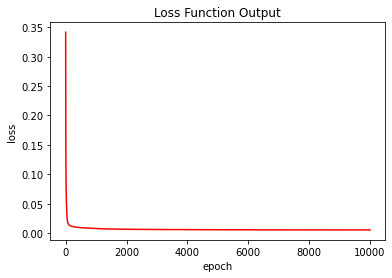

In [14]:
results_train_loss = his.history['loss']
plt.plot(results_train_loss, color='red')
plt.title('Loss Function Output')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [15]:
results_train_loss[10000-1]

0.005373641382902861

#### Plot Trained Model Ouput

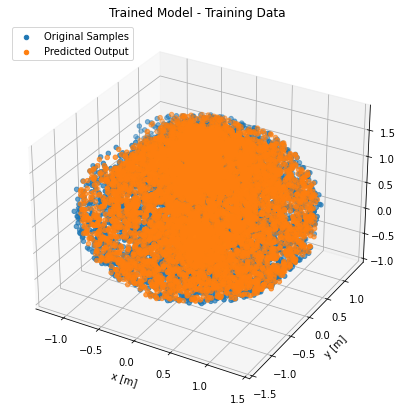

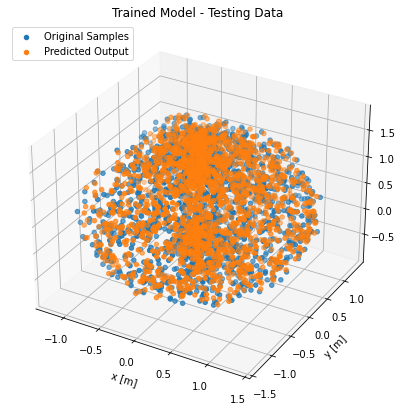

In [16]:
def plot_model(model_orig, x_true, y_true, arg):
    y_predict = model_orig.predict(x_true)
    
    
    fig = plt.figure(figsize = (10, 7))
    ax = plt.axes(projection ="3d")
 
    ## training output
    ax.scatter3D(y_true[:, 0], y_true[:, 1], y_true[:, 2], 'ro', label='Original Samples')

    ## predicted output
    ax.scatter3D(y_predict[:, 0], y_predict[:, 1], y_predict[:, 2], 'ko', label='Predicted Output')
    plt.title(arg)
    plt.xlabel('x [m]')
    plt.ylabel('y [m]')
    plt.legend(loc="upper left")
    
    
    plt.xlim([np.min(y_train[:, 0]), np.max(y_train[:, 0])])
    plt.ylim([np.min(y_train[:, 1]), np.max(y_train[:, 1])])
    plt.savefig('books_read.jpg', dpi=600)
    plt.show()
    
    return y_predict

y_predict_train = plot_model(model_orig, x_train, y_train, arg='Trained Model - Training Data')
y_predict_test = plot_model(model_orig, x_test, y_test, arg='Trained Model - Testing Data')

In [17]:
y_predict_train

array([[-0.53660214,  0.81910694,  0.9325448 ,  1.0014148 ],
       [-0.11518227, -1.1014705 , -0.27843243,  1.0024568 ],
       [ 0.5107972 , -0.9954024 ,  0.72481126,  1.002228  ],
       ...,
       [ 0.17996703,  0.05240966, -0.50229925,  0.9962745 ],
       [-0.24904697, -1.2468519 , -0.15498996,  0.99965954],
       [-0.42860323,  0.9389033 ,  1.0544776 ,  1.0029427 ]],
      dtype=float32)

In [18]:
my_data10 = genfromtxt('data10.csv', delimiter=',')

In [19]:
x1_valid = my_data10[0:,0:6]
x_valid = reshape_cos_sin(x1_valid)
y_valid = my_data10[0:,6:]

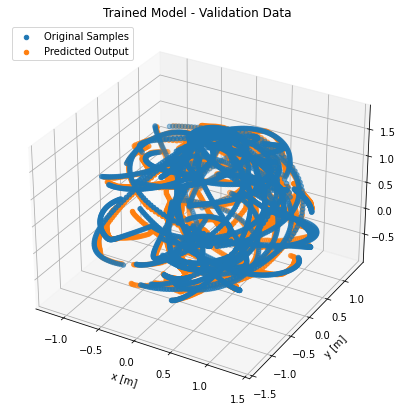

In [20]:
y_predict_valid = plot_model(model_orig, x_valid, y_valid, arg='Trained Model - Validation Data')


### Error Calculator

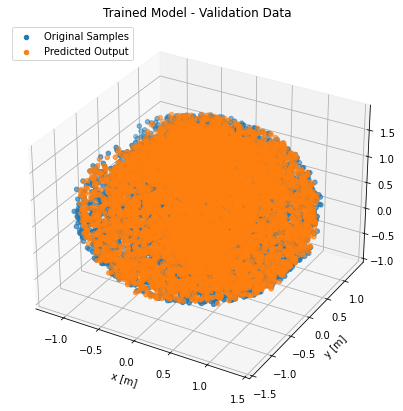

In [21]:
y_valid2 = y
y_predict_valid2 = plot_model(model_orig, x, y, arg='Trained Model - Validation Data')

In [22]:
error = y_predict_valid2-y_valid2

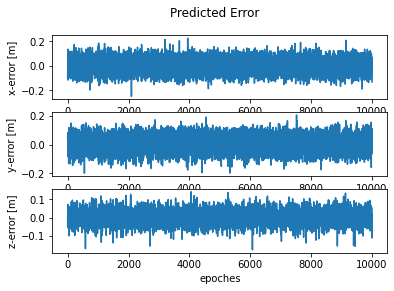

In [23]:
fig, (ax1, ax2, ax3) = plt.subplots(3)
fig.suptitle('Predicted Error')
ax1.plot(error[0:,0])
ax1.set(ylabel = 'x-error [m]')
ax2.plot(error[0:,1])
ax2.set(ylabel = 'y-error [m]')
ax3.plot(error[0:,2])
ax3.set(ylabel = 'z-error [m]',xlabel = 'epoches')
plt.show()

### Repair Data

In [24]:
# separate data inside and outside of the desired bound
x_in_b = np.zeros((1,12))
y_in_b = np.zeros((1,4))
x_out_b = np.zeros((1,12))
y_out_b = np.zeros((1,4))

for i in range(y_predict_valid2.shape[0]):
    if i == 0:
        if y_predict_valid2[i,0]>.5:
            x_out_b = x[i,]
            y_out_b = y[i,]
        else:
            x_in_b = x[i,]
            y_in_b = y[i,]
    else:
        if y_predict_valid2[i,0]>.5:
            x_out_b = np.vstack((x_out_b,x[i,]))
            y_out_b = np.vstack((y_out_b,y[i,]))
        else:
            x_in_b = np.vstack((x_in_b,x[i,]))
            y_in_b = np.vstack((y_in_b,y[i,]))

In [25]:
x_out_b=np.delete(x_out_b, 0, 0)
y_out_b=np.delete(y_out_b, 0, 0)

#### Repair Batch Creator

In [26]:
class Batch_repair(object):
    def __init__(self, X_in_col, Y_in_col, X_out_col, Y_out_col, repair_samp_size, out_in_portion):
        self.X_in = X_in_col
        self.Y_in = Y_in_col
        self.X_out = X_out_col
        self.Y_out = Y_out_col
        self.size = repair_samp_size
        self.in_size = int(repair_samp_size * out_in_portion)
        self.out_size = int(repair_samp_size - self.in_size)

    def getBatch(self):
        values = range(self.size)
        in_dataset, _ = train_test_split(range(self.X_in.shape[0]), train_size=self.in_size, test_size=self.in_size)
        out_dataset, _ = train_test_split(range(self.X_out.shape[0]), train_size=self.out_size, test_size=self.out_size)
        # indices = np.random.choice(range(self.size), self.batch_size)  # sampling with replacement
        return self.X_in[in_dataset, :], self.Y_in[in_dataset, :], self.X_out[out_dataset, :], self.Y_out[out_dataset, :]
    
repair_samp_size = 100
out_in_portion = 0.5 
batch_repair = Batch_repair(x_in_b, y_in_b, x_out_b, y_out_b, repair_samp_size, out_in_portion)
#batch_repair.getBatch()

In [27]:
x_in, y_in, x_out, y_out = batch_repair.getBatch()

### Replicate the Original NN

#### Classes (NN with Numpy)

In [28]:
class Dense:
    def __init__(self, nin, nout):
        self.weights = np.random.rand(nin, nout) * 2 - 1
        self.bias = np.random.rand(nout) * 2 - 1
        
    def _relu(self, x):
        return np.maximum(x, 0)
    
    def __call__(self, x, relu=False):
        x = x @ self.weights + self.bias
        if relu:
            x = self._relu(x)
            
        return x

    def set_variables(self, weights=None, bias=None):
        if weights is not None:
            self.weights[:] = weights[:]
            
        if bias is not None:
            self.bias[:] = bias[:]
            
class MLP:
    def __init__(self, nin, uout, uhidden):
        self.num_layer = len(uhidden)+1
        prev = nin
        self.layers = []
        for u in uhidden:
            self.layers.append(Dense(prev, u))
            prev = u
        self.layers.append(Dense(prev, uout))
        
    def __call__(self, x, relu=False):
        
        if self.num_layer == 2:
            x1 = self.layers[0](x, relu=True)
            y = self.layers[1](x1, relu=relu)
            return x1, y
        
        if self.num_layer == 3:
            x1 = self.layers[0](x, relu=True)
            x2 = self.layers[1](x1, relu=True)
            y = self.layers[2](x2, relu=relu)
            return x1, x2, y
        if self.num_layer == 4:
            x1 = self.layers[0](x, relu=True)
            x2 = self.layers[1](x1, relu=True)
            x3 = self.layers[2](x2, relu=True)
            y = self.layers[3](x3, relu=relu)
            return x1, x2, x3, y

#### Reconstruct the Original NN to Obtain Diferrent Layer values given Input x0

In [29]:
#Rounding weights to the fifth decimal place
w0_orig=np.round(w0_orig, 5)   
w1_orig=np.round(w1_orig, 5)  
w2_orig=np.round(w2_orig, 5) 
w3_orig=np.round(w3_orig, 5)

b0_orig=np.round(b0_orig,5)
b1_orig=np.round(b1_orig,5)
b2_orig=np.round(b2_orig,5)
b3_orig=np.round(b3_orig,5)

### Shrink Data

In [30]:
x_train_new = np.vstack((x_in,x_out))
y_train_new = np.vstack((y_in,y_out))

In [31]:

#x_train_new = x_train[0:7000,0:]
#y_train_new = y_train[0:7000,0:]
#x_test_new = x_test[0:7000,0:]
#y_test_new = y_test[0:7000,0:]

In [32]:
num_output

4

In [33]:
mlp_orig = MLP(num_input, num_output, [num_hidden_0, num_hidden_1, num_hidden_2])
mlp_orig.layers[0].weights=w0_orig   
mlp_orig.layers[1].weights=w1_orig  
mlp_orig.layers[2].weights=w2_orig  
mlp_orig.layers[3].weights=w3_orig  
mlp_orig.layers[0].bias=b0_orig
mlp_orig.layers[1].bias=b1_orig
mlp_orig.layers[2].bias=b2_orig
mlp_orig.layers[3].bias=b3_orig

X0_orig_train, X1_orig_train, X2_orig_train, Y_orig_train = mlp_orig(x_train_new, relu=False)
# print("w0= "+str(w_0))
# print("w1= "+str(w_1))
# print("b0= "+str(b_0))
# print("b1= "+str(b_1))
# print("x_train= "+str(x_train))
# print("hiddel_layer= "+str(h_copy))
# print("y_predicted= "+str(y_copy))


In [34]:
x_train_new.shape

(100, 12)

## Repair the network with the modification of the last layer

Repairing last layer $\mathbf{W}_{new}^3 \mathbf{x}^3 + \mathbf{b}_{new}^3 = \mathbf{y}$:

\begin{align}
       & \min_{\mathbf{W}^3,\mathbf{b}^3}
       & & \frac{1}{2}\sum^{N}_{n=1}|| \mathbf{y}(\mathbf{x}^3_n,\mathbf{W}^3,\mathbf{b}^3)-\mathbf{t}_n||^2_2, \\
       & \text{s.t.} & &   \mathbf{W}_{new}^3 \mathbf{x}^3 + \mathbf{b}_{new}^3 = \mathbf{y},\\
       & & & \mathbf{A}\mathbf{y}\leq b.
\end{align}


### Build 1 Layer MIP NN

#### classes

In [35]:
class MIPLayer:
    def __init__(self, model, uin, uout, param_bounds=(-1, 1)):
        model.nlayers = getattr(model, 'nlayers', 0)
        self.uin, self.uout = uin, uout
        
        w_l, b_l = 'w' + str(model.nlayers), 'b' + str(model.nlayers)
        
        setattr(model, w_l, pyo.Var(range(uin), range(uout), domain=pyo.Reals, bounds=param_bounds))
        setattr(model, b_l, pyo.Var(range(uout), domain=pyo.Reals, bounds=param_bounds))
        
        self.w = getattr(model, w_l)
        self.b = getattr(model, b_l)
        
        model.nlayers += 1
        self.model = model
        
    def __call__(self, x, shape, relu=False, output_bounds=(-1e1, 1e1)):
        self.model.lout = getattr(self.model, 'lout', 0) + 1
#         print(self.model.nlayers)
        if relu:
            return self._relu_constraints(x, shape, self.model.lout, output_bounds)
        return self._constraints(x, shape, self.model.lout, output_bounds)
    
    def _relu_constraints(self, x, shape, l, output_bounds=(-1e1, 1e1)):
        m, n = shape
        assert n == self.uin
        
        x_l, s_l, theta_l = 'x'+str(l), 's'+str(l), 'theta'+str(l)
        
        setattr(self.model, x_l, pyo.Var(range(m), range(self.uout), domain=pyo.NonNegativeReals, bounds=output_bounds))
        setattr(self.model, s_l, pyo.Var(range(m), range(self.uout), domain=pyo.NonNegativeReals, bounds=output_bounds))
        setattr(self.model, theta_l, pyo.Var(range(m), range(self.uout), domain=pyo.Binary))
        
        def constraints(model, i, j):
            product = self.b[j]
            for k in range(self.uin):
                product += x[i, k] * self.w[k, j]
            return product == getattr(model, x_l)[i, j] - getattr(model, s_l)[i, j]
        
        setattr(self.model, 'eq_constraint'+str(l),
                pyo.Constraint(range(m), range(self.uout), rule=constraints))
        
        def disjuncts(model, i, j):
            return [(getattr(model, theta_l)[i, j] == 0, getattr(model, x_l)[i, j] <= 0),
                    (getattr(model, theta_l)[i, j] == 1, getattr(model, s_l)[i, j] <= 0)]
        
        setattr(self.model, 'disjunction'+str(l), pyg.Disjunction(range(m), range(self.uout), rule=disjuncts))
        return  getattr(self.model, x_l)
        
    def _constraints(self, x, shape, l, output_bounds=(-1e1, 1e1)):
        m, n = shape
        assert n == self.uin
        
        x_l = 'x'+str(l)
        setattr(self.model, x_l, pyo.Var(range(m), range(self.uout), domain=pyo.Reals, bounds=output_bounds))
        
        def constraints(model, i, j):
            product = self.b[j]
            for k in range(self.uin):
                product += x[i, k] * self.w[k, j]
            return product == getattr(model, x_l)[i, j]

        def constraint_inside0(model, i):
             return(getattr(model, x_l)[i, 0] -0.5 <= 0)
        
       
        setattr(self.model, 'eq_constraint'+str(l),
                pyo.Constraint(range(m), range(self.uout), rule=constraints))
        setattr(self.model, 'keep_inside_constraint0'+str(l),
                 pyo.Constraint(range(m), rule=constraint_inside0))

        
        return getattr(self.model, x_l)

In [36]:
class MIPNNModel:
    def __init__(self, uin, uout, uhidden, param_bounds=(-1, 1)):
        self.model = pyo.ConcreteModel()
        
        self.model.nlayers = 0
        
        self.uin, self.uout = uin, uout
        
        self.layers = []
        prev = uin
        for u in uhidden:
            self.layers.append(MIPLayer(self.model, prev, u, param_bounds))
            prev = u
        self.layers.append(MIPLayer(self.model, prev, uout, param_bounds))
        
    def __call__(self, x, shape, relu=False, output_bounds=(-1e1, 1e1)):
        m, n = shape
        assert n == self.uin
        
        for layer in self.layers[:-1]:
            x = layer(x, (m, layer.uin), relu=True, output_bounds=output_bounds)
        
        layer = self.layers[-1]
        y = layer(x, (m, layer.uin), relu=relu, output_bounds=output_bounds)
        return y

#### Building 1 Layer

In [37]:
num_samples = X2_orig_train.shape[0]
mip_model_layer4 = MIPNNModel(num_hidden_2, num_output, [])
y_ = mip_model_layer4(X2_orig_train, (num_samples, num_hidden_2))
#print(y_train)

model_lay4 = mip_model_layer4.model
#pprint(vars(model_lay3))
#print(mip_model_layer3.model.eq_constraint1[(0,0)])

print(y_)

x1


#### Final Output and Ojbective

In [38]:
def squared_sum(x, y, m, n):
    _squared_sum = 0
    for i in range(m):
        for j in range(n):
            _squared_sum += (x[i, j] - y[i, j]) ** 2
    return _squared_sum

cost_expr = squared_sum(y_, y_train_new, num_samples, num_output) ## check correctness

# regularization term for weigts
for j in range(num_output):
    cost_expr += regularizer_rate*model_lay4.b0[j]**2
    for i in range(num_hidden_2):
        cost_expr += regularizer_rate*model_lay4.w0[i, j]**2



model_lay4.obj = pyo.Objective(expr=cost_expr)
pyo.TransformationFactory('gdp.bigm').apply_to(model_lay4)
opt = pyo.SolverFactory('gurobi',solver_io="python")

opt.solve(model_lay4, tee=True)

Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Changed value of parameter LogFile to C:\Users\kmajd1\AppData\Local\Temp\tmpfiiftebr.log
   Prev:   Default: 
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 500 rows, 484 columns and 5532 nonzeros
Model fingerprint: 0xc937a5a7
Model has 484 quadratic objective terms
Coefficient statistics:
  Matrix range     [3e-04, 1e+00]
  Objective range  [1e-03, 3e+00]
  QObjective range [2e-04, 2e+00]
  Bounds range     [1e+00, 1e+01]
  RHS range        [5e-01, 5e-01]
Presolve removed 100 rows and 12 columns
Presolve time: 0.03s
Presolved: 400 rows, 472 columns, 5432 nonzeros
Presolved model has 472 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.980e+04
 Factor NZ  : 2.020e+04 (roughly 1 MByte of memory)
 Factor Ops : 1.353e+06 (less than 1 second per iteration)
 Threads    : 1

      

{'Problem': [{'Name': 'unknown', 'Lower bound': 13.853381862240354, 'Upper bound': 13.853381862240354, 'Number of objectives': 1, 'Number of constraints': 500, 'Number of variables': 484, 'Number of binary variables': 0, 'Number of integer variables': 0, 'Number of continuous variables': 484, 'Number of nonzeros': 5532, 'Sense': 1, 'Number of solutions': 1}], 'Solver': [{'Name': 'Gurobi 9.10', 'Status': 'ok', 'Wallclock time': 0.1382465362548828, 'Termination condition': 'optimal', 'Termination message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.'}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [39]:
# original_stdout = sys.stdout # Save a reference to the original standard output

# with open('last_layer_mip_model.txt', 'w') as f:
#     sys.stdout = f # Change the standard output to the file we created.
#     model_lay4.pprint()
#     sys.stdout = original_stdout # Reset the standard output to its original value

In [40]:
model_lay4.w0.display()

w0 : Size=80, Index=w0_index
    Key     : Lower : Value                   : Upper : Fixed : Stale : Domain
     (0, 0) :    -1 :                    -0.0 :     1 : False : False :  Reals
     (0, 1) :    -1 :                    -0.0 :     1 : False : False :  Reals
     (0, 2) :    -1 :                    -0.0 :     1 : False : False :  Reals
     (0, 3) :    -1 :                    -0.0 :     1 : False : False :  Reals
     (1, 0) :    -1 :     -0.7951727251716587 :     1 : False : False :  Reals
     (1, 1) :    -1 :     -0.9999249668949943 :     1 : False : False :  Reals
     (1, 2) :    -1 :     0.31146928655182005 :     1 : False : False :  Reals
     (1, 3) :    -1 :   -0.001462109014071844 :     1 : False : False :  Reals
     (2, 0) :    -1 :   -0.003057552964757404 :     1 : False : False :  Reals
     (2, 1) :    -1 :      0.7158685241982405 :     1 : False : False :  Reals
     (2, 2) :    -1 :      0.3735391672056221 :     1 : False : False :  Reals
     (2, 3) :    -1 :  

In [41]:
model_lay4.b0.display()

b0 : Size=4, Index=b0_index
    Key : Lower : Value                : Upper : Fixed : Stale : Domain
      0 :    -1 :   0.8628634341000117 :     1 : False : False :  Reals
      1 :    -1 : -0.06022413869276366 :     1 : False : False :  Reals
      2 :    -1 :  0.42702262646479205 :     1 : False : False :  Reals
      3 :    -1 :   0.9945796571766294 :     1 : False : False :  Reals


In [42]:
print(w3_orig) #previously trained nn weights
print(b3_orig) #previously trained nn bias

[[-1.69000e-03 -5.00000e-04 -3.21000e-03  9.90000e-04]
 [-1.89450e-01 -6.43400e-02 -1.32070e-01  2.18200e-02]
 [-5.95640e-01  7.84100e-01  4.16250e-01 -9.15000e-03]
 [ 8.80000e-04  2.37000e-03 -3.70000e-04  2.20000e-04]
 [-1.05870e-01  3.04020e-01  1.26830e-01  7.94000e-03]
 [ 8.67000e-03 -1.83900e-02  4.05000e-02  2.42500e-02]
 [-1.53000e-01  4.68840e-01 -8.22360e-01  7.34800e-02]
 [ 2.85620e-01 -5.61290e-01 -5.17930e-01  6.77400e-02]
 [-1.04011e+00 -9.82400e-02  2.83790e-01 -1.99000e-03]
 [-5.09300e-02 -7.31150e-01  4.30970e-01  2.02400e-02]
 [-8.10000e-03 -1.42710e-01 -1.93780e-01  2.92700e-02]
 [-6.62600e-02 -2.38530e-01 -1.54880e-01  1.00300e-02]
 [ 3.90900e-02  1.49200e-01  5.38300e-01  2.71940e-01]
 [-1.94920e-01 -3.72520e-01  2.23290e-01  3.14900e-02]
 [ 7.11880e-01  5.39150e-01  3.37980e-01 -2.20300e-02]
 [ 7.82650e-01  2.31590e-01  4.31920e-01 -4.75000e-03]
 [ 4.18370e-01 -6.32300e-01  7.63500e-02 -7.78000e-03]
 [-4.07870e-01 -7.30270e-01  2.70920e-01 -1.48400e-02]
 [-2.76000

In [43]:
model_lay4.x1.display()

x1 : Size=400, Index=x1_index
    Key     : Lower : Value                  : Upper : Fixed : Stale : Domain
     (0, 0) : -10.0 :    -0.2095700611814184 :  10.0 : False : False :  Reals
     (0, 1) : -10.0 :    0.12710826439324663 :  10.0 : False : False :  Reals
     (0, 2) : -10.0 :     1.5681910252186153 :  10.0 : False : False :  Reals
     (0, 3) : -10.0 :     0.9998365971203622 :  10.0 : False : False :  Reals
     (1, 0) : -10.0 :   0.014163287585484241 :  10.0 : False : False :  Reals
     (1, 1) : -10.0 :    0.15059697447855847 :  10.0 : False : False :  Reals
     (1, 2) : -10.0 :    -0.2718153312026157 :  10.0 : False : False :  Reals
     (1, 3) : -10.0 :     1.0001056697239932 :  10.0 : False : False :  Reals
     (2, 0) : -10.0 :     0.3045109695576791 :  10.0 : False : False :  Reals
     (2, 1) : -10.0 :     0.3422719856240679 :  10.0 : False : False :  Reals
     (2, 2) : -10.0 :    -0.7596896169815732 :  10.0 : False : False :  Reals
     (2, 3) : -10.0 :     0.999934

    (47, 1) : -10.0 :    -0.3747654903391471 :  10.0 : False : False :  Reals
    (47, 2) : -10.0 :      1.591523032809345 :  10.0 : False : False :  Reals
    (47, 3) : -10.0 :     0.9999505649234308 :  10.0 : False : False :  Reals
    (48, 0) : -10.0 :     0.3758482574749227 :  10.0 : False : False :  Reals
    (48, 1) : -10.0 :   -0.12307520308771025 :  10.0 : False : False :  Reals
    (48, 2) : -10.0 :     1.0793186305936402 :  10.0 : False : False :  Reals
    (48, 3) : -10.0 :     0.9999095565596523 :  10.0 : False : False :  Reals
    (49, 0) : -10.0 :   -0.01400764729480386 :  10.0 : False : False :  Reals
    (49, 1) : -10.0 :    0.01535836014952352 :  10.0 : False : False :  Reals
    (49, 2) : -10.0 :   0.028446880630145444 :  10.0 : False : False :  Reals
    (49, 3) : -10.0 :       1.00000526112831 :  10.0 : False : False :  Reals
    (50, 0) : -10.0 :    0.14920972365859164 :  10.0 : False : False :  Reals
    (50, 1) : -10.0 :    -1.1428914195166637 :  10.0 : False : F

In [44]:
print(Y_orig_train)

[[-1.83130204e-01  1.39025347e-01  1.55696279e+00  9.95527565e-01]
 [ 4.40028343e-02  1.45692511e-01 -2.77664268e-01  1.00613165e+00]
 [ 4.73152489e-01  3.07830705e-01 -7.53945712e-01  1.00027034e+00]
 [ 1.21350469e-02  7.22293404e-02 -8.67617340e-02  9.97473341e-01]
 [ 6.20279441e-02 -1.10883804e+00  2.89716526e-01  1.00221913e+00]
 [ 6.18147851e-02 -2.01762199e-01  1.25648848e+00  1.00181995e+00]
 [-1.12375123e-01  2.93909014e-01  1.29267387e+00  9.99458537e-01]
 [-1.00632384e+00 -9.28950674e-01  4.08105033e-01  9.97593590e-01]
 [-6.67658360e-01 -6.19981950e-01 -4.17902197e-02  9.97902795e-01]
 [-6.02330902e-01  1.23105057e+00  2.03474598e-01  1.00048895e+00]
 [-2.28396864e-01 -1.11521948e+00  7.61035657e-01  9.99126094e-01]
 [-4.01551511e-01 -4.81981672e-01 -5.64477145e-01  1.00674649e+00]
 [-3.48902670e-01 -4.15166909e-01  7.61381545e-01  9.95130663e-01]
 [-3.66571161e-01  2.37070592e-01 -5.08604133e-01  9.95262177e-01]
 [ 1.45216626e-01 -3.76184202e-02  1.62966695e+00  9.99334465e

In [45]:
y_new = np.zeros((num_samples, num_output))
w3_new = np.zeros((num_hidden_2, num_output))
b3_new = np.zeros((1, num_output))
for i in range(num_samples):
    for j in range(num_output):
        y_new[i, j] = model_lay4.x1[i, j].value
for j in range(num_output):
    b3_new[0, j] = model_lay4.b0[j].value
    for i in range(num_hidden_2):
        w3_new[i, j] = model_lay4.w0[i, j].value
print(w3_new)
print(b3_new)


[[-0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00]
 [-7.95172725e-01 -9.99924967e-01  3.11469287e-01 -1.46210901e-03]
 [-3.05755296e-03  7.15868524e-01  3.73539167e-01 -6.10422494e-04]
 [-0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00]
 [-7.78610027e-01  7.19594366e-01  1.75403227e-01 -4.06744837e-04]
 [-1.00000000e+00  6.50551882e-01  9.99999993e-01  7.04130293e-03]
 [-4.47448431e-01  6.30790432e-01 -9.63590589e-01  3.31641470e-03]
 [-6.89744937e-01 -8.22438176e-01 -5.04920574e-01  3.21448585e-03]
 [-1.00000000e+00 -1.83326637e-01  2.84278917e-01  5.88381892e-04]
 [-1.00000000e+00 -6.58249262e-01  3.86486895e-01 -1.11831444e-03]
 [ 1.00000000e+00  9.99999997e-01 -7.60156055e-01  3.66825119e-04]
 [ 1.00000000e+00 -3.91263934e-01 -1.40530304e-01 -1.60056677e-03]
 [-1.00000000e+00  2.03674825e-01  1.68746870e-01  1.15525011e-02]
 [-5.36624981e-01 -4.36088552e-01  1.11478477e-01  4.68283845e-04]
 [ 4.07078999e-01  7.40370990e-01  4.25776309e-01 -1.60365067e

#### Build Refined NN 

In [46]:
mlp_lay4 = MLP(num_input, num_output, [num_hidden_0, num_hidden_1, num_hidden_2])
mlp_lay4.layers[0].weights=w0_orig   
mlp_lay4.layers[1].weights=w1_orig  
mlp_lay4.layers[2].weights=w2_orig  
mlp_lay4.layers[3].weights=w3_new  
mlp_lay4.layers[0].bias=b0_orig
mlp_lay4.layers[1].bias=b1_orig
mlp_lay4.layers[2].bias=b2_orig
mlp_lay4.layers[3].bias=b3_new

_, _, _, y_new_train = mlp_lay4(x_train, relu=False)

#### Plot New Results

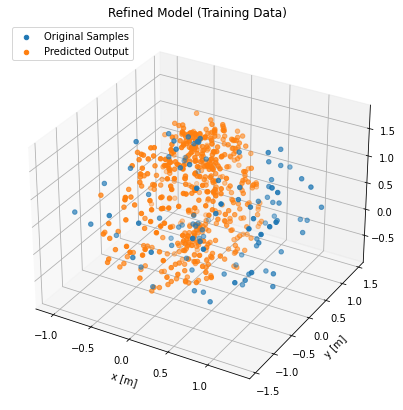

In [47]:
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
 
## training output
ax.scatter3D(y_train_new[0:500, 0], y_train_new[0:500, 1], y_train_new[0:500, 2], 'ro', label='Original Samples')

## predicted output
ax.scatter3D(y_new_train[0:500, 0], y_new_train[0:500, 1], y_new_train[0:500, 2], 'ko', label='Predicted Output')
plt.title('Refined Model (Training Data)')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.legend(loc="upper left")
    
plt.show()

In [48]:
import pickle 

with open('model_refined/y_train_original.data', 'wb') as filehandle:
    # store the data as binary data stream
    pickle.dump(y_train, filehandle)
    
with open('model_refined/y_new_last_layer.data', 'wb') as filehandle:
    # store the data as binary data stream
    pickle.dump(y_new_train, filehandle)

## Repair the network with the modification of the third layer

### Replicate the Original NN

#### Classes (NN with Numpy)

In [49]:
class MIPLayer1:
    def __init__(self, model, uin, uout, w2, b2, last_layer, param_bounds=(-1, 1)):
        model.nlayers = getattr(model, 'nlayers', 0)
        self.uin, self.uout = uin, uout
        if last_layer == False:
            w_l, b_l = 'w' + str(model.nlayers), 'b' + str(model.nlayers)
        
            setattr(model, w_l, pyo.Var(range(uin), range(uout), domain=pyo.Reals, bounds=param_bounds))
            setattr(model, b_l, pyo.Var(range(uout), domain=pyo.Reals, bounds=param_bounds))
        
            self.w = getattr(model, w_l)
            self.b = getattr(model, b_l)
        else:
            self.w=w2
            self.b=b2
        model.nlayers += 1
        self.model = model
        
    def __call__(self, x, shape, relu=False, output_bounds=(-1e1, 1e1)):
        self.model.lout = getattr(self.model, 'lout', 0) + 1
#         print(self.model.nlayers)
        if relu:
            return self._relu_constraints(x, shape, self.model.lout, output_bounds)
        return self._constraints(x, shape, self.model.lout, output_bounds)
    
    def _relu_constraints(self, x, shape, l, output_bounds=(-1e1, 1e1)):
        m, n = shape
        assert n == self.uin
        
        x_l, s_l, theta_l = 'x'+str(l), 's'+str(l), 'theta'+str(l)
        
        setattr(self.model, x_l, pyo.Var(range(m), range(self.uout), domain=pyo.NonNegativeReals, bounds=output_bounds))
        setattr(self.model, s_l, pyo.Var(range(m), range(self.uout), domain=pyo.NonNegativeReals, bounds=output_bounds))
        setattr(self.model, theta_l, pyo.Var(range(m), range(self.uout), domain=pyo.Binary))
        
        def constraints(model, i, j):
            product = self.b[j]
            for k in range(self.uin):
                product += np.round(x[i, k], 4) * self.w[k, j]
            return product == getattr(model, x_l)[i, j] - getattr(model, s_l)[i, j]
        
        setattr(self.model, 'eq_constraint'+str(l),
                pyo.Constraint(range(m), range(self.uout), rule=constraints))
        
        def disjuncts(model, i, j):
            return [(getattr(model, theta_l)[i, j] == 0, getattr(model, x_l)[i, j] <= 0),
                    (getattr(model, theta_l)[i, j] == 1, getattr(model, s_l)[i, j] <= 0)]
        
        setattr(self.model, 'disjunction'+str(l), pyg.Disjunction(range(m), range(self.uout), rule=disjuncts))
        return  getattr(self.model, x_l)
        
    def _constraints(self, x, shape, l, output_bounds=(-1e1, 1e1)):
        m, n = shape
        assert n == self.uin
        
        x_l = 'x'+str(l)
        setattr(self.model, x_l, pyo.Var(range(m), range(self.uout), domain=pyo.Reals, bounds=output_bounds))
        
        def constraints(model, i, j):
            product = np.round(self.b[j],4)
            for k in range(self.uin):
                product += x[i, k] * np.round(self.w[k, j],4)
            return product == getattr(model, x_l)[i, j]

        def constraint_inside0(model, i):
             return(getattr(model, x_l)[i, 0] - 0.5 <= 0)
       
        setattr(self.model, 'eq_constraint'+str(l),
                pyo.Constraint(range(m), range(self.uout), rule=constraints))
        setattr(self.model, 'keep_inside_constraint0'+str(l),
                 pyo.Constraint(range(m), rule=constraint_inside0))
        
        return getattr(self.model, x_l)

In [50]:
class MIPNNModel1:
    def __init__(self, uin, uout, uhidden, w2, b2, param_bounds=(-1, 1)):
        self.model = pyo.ConcreteModel()
        
        self.model.nlayers = 0
        
        self.uin, self.uout = uin, uout
        
        self.layers = []
        prev = uin
        for u in uhidden:
            self.layers.append(MIPLayer1(self.model, prev, u, w2, b2, False, param_bounds))
            prev = u
        self.layers.append(MIPLayer1(self.model, prev, uout, w2, b2, True, param_bounds))
        
    def __call__(self, x, shape, relu=False, output_bounds=(-1e1, 1e1)):
        m, n = shape
        assert n == self.uin
        
        for layer in self.layers[:-1]:
            x = layer(x, (m, layer.uin), relu=True, output_bounds=output_bounds)
        
        layer = self.layers[-1]
        y = layer(x, (m, layer.uin), relu=relu, output_bounds=output_bounds)
        return y

#### Building the middle layer with the fixed weights for the final layer

In [51]:
num_samples = X1_orig_train.shape[0]
mip_model_layer3 = MIPNNModel1(num_hidden_1, num_output, [num_hidden_2], w3_orig, b3_orig)
y_ = mip_model_layer3(np.round(X1_orig_train,3), (num_samples, num_hidden_1))


model_lay3 = mip_model_layer3.model
#pprint(vars(model_lay2))
#pprint(mip_model_layer2.model.eq_constraint1)
#print(y_)

#### Final Output and Ojbective

In [52]:
def squared_sum(x, y, m, n):
    _squared_sum = 0
    for i in range(m):
        for j in range(n):
            _squared_sum += (x[i, j] - y[i, j]) ** 2
    return _squared_sum

cost_expr = squared_sum(y_, np.round(y_train_new,3), num_samples, num_output) ## check correctness

# regularization term for weigts
for j in range(num_hidden_2):
    cost_expr += regularizer_rate*model_lay3.b0[j]**2
    for i in range(num_hidden_1):
        cost_expr += regularizer_rate*model_lay3.w0[i, j]**2



model_lay3.obj = pyo.Objective(expr=cost_expr)
pyo.TransformationFactory('gdp.bigm').apply_to(model_lay3)
opt = pyo.SolverFactory('gurobi')
opt.options['TimeLimit'] = 36000
opt.options['mipgap'] = 0.04
opt.solve(model_lay3, tee=True)


Using license file C:\Users\kmajd1\gurobi.lic
Academic license - for non-commercial use only - expires 2022-08-25
Read LP format model from file C:\Users\kmajd1\AppData\Local\Temp\tmpbmkf9yyz.pyomo.lp
Reading time = 0.14 seconds
: 16501 rows, 10821 columns, 65481 nonzeros
Changed value of parameter TimeLimit to 36000.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter mipgap to 0.04
   Prev: 0.0001  Min: 0.0  Max: inf  Default: 0.0001
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 16501 rows, 10821 columns and 65481 nonzeros
Model fingerprint: 0x34f31e30
Model has 820 quadratic objective terms
Variable types: 4821 continuous, 6000 integer (6000 binary)
Coefficient statistics:
  Matrix range     [2e-04, 1e+01]
  Objective range  [1e-02, 2e+02]
  QObjective range [2e-04, 2e+00]
  Bounds range     [1e+00, 1e+01]
  RHS range        [9e-03, 1e+01]
Presolve remo

 37127 28874    9.00114  325  998   12.45642    8.95611  28.1%   413 1246s
H37853 28892                      12.4564185    8.95611  28.1%   410 1332s
H37860 28892                      12.4564184    8.95611  28.1%   410 1332s
H37863 28873                      12.4304429    8.95611  28.0%   410 1332s
 37877 29174    9.10401  368  937   12.43044    8.95611  28.0%   410 1356s
H38004 28929                      12.2590480    8.95611  26.9%   409 1356s
H38007 28409                      11.9032684    8.95611  24.8%   409 1356s
H38010 27999                      11.6286249    8.95611  23.0%   409 1356s
H38049 27970                      11.6113512    8.95611  22.9%   409 1356s
 38190 29276    9.17828  376  918   11.61135    8.95611  22.9%   409 1374s
H38566 28072                      10.9349064    8.95611  18.1%   407 1374s
H38567 28055                      10.9252024    8.95611  18.0%   407 1374s
 39634 28841    9.33929  457  877   10.92520    8.95611  18.0%   400 1391s
 40679 30563    9.38656  

 142710 98913    8.96014  187  930    9.70271    8.95611  7.69%   249 2683s
 143721 100219     cutoff  384         9.70271    8.95611  7.69%   249 2696s
 145284 100785    9.68741  191 1115    9.70271    8.95611  7.69%   249 2710s
 145943 102584 infeasible  230         9.70271    8.95611  7.69%   249 2724s
 147845 104008    8.99458  309 1023    9.70271    8.95611  7.69%   248 2738s
 149429 104958    8.95641   92  649    9.70271    8.95611  7.69%   247 2749s
 150454 105517    8.95747  216 1053    9.70271    8.95611  7.69%   247 2765s
 151061 106987    8.95833  252 1020    9.70271    8.95611  7.69%   247 2780s
 152567 107976    8.96128  286 1080    9.70271    8.95611  7.69%   246 2792s
 153639 109321    8.97129  344  952    9.70271    8.95611  7.69%   247 2805s
 155151 110474    8.99806  370  936    9.70271    8.95611  7.69%   246 2817s
 156306 111369    9.12759  425  871    9.70271    8.95611  7.69%   246 2829s
 157275 112470    9.25732  454  820    9.70271    8.95611  7.69%   246 2844s


 245092 169532    8.98601  457  832    9.42963    8.95611  5.02%   233 4097s
 246255 170108    9.01616  492  793    9.42963    8.95611  5.02%   233 4108s
 246833 171084    9.07154  516  761    9.42963    8.95611  5.02%   233 4122s
 247826 172344    9.12838  550  680    9.42963    8.95611  5.02%   233 4137s
 249142 173474    9.15987  577  667    9.42963    8.95611  5.02%   233 4152s
 250347 173830    9.20229  600  656    9.42963    8.95611  5.02%   233 4168s
H250438 173830                       9.4296310    8.95611  5.02%   233 4168s
 250703 174726    9.22695  628  626    9.42963    8.95611  5.02%   233 4182s
 251607 175673    9.25890  656  603    9.42963    8.95611  5.02%   233 4197s
 252678 177005    9.29130  682  596    9.42963    8.95611  5.02%   233 4212s
 254087 177908     cutoff  701         9.42963    8.95611  5.02%   233 4230s
 255076 179671    9.35295  753  569    9.42963    8.95611  5.02%   233 4245s
 257006 181488     cutoff  798         9.42963    8.95611  5.02%   232 4261s

 362180 258278    9.33483 1103  348    9.33711    8.95611  4.08%   217 5415s
H364123 258286                       9.3371086    8.95611  4.08%   216 5429s
H364124 258286                       9.3371085    8.95611  4.08%   216 5429s
H364125 258286                       9.3371084    8.95611  4.08%   216 5429s
H364130 258286                       9.3371083    8.95611  4.08%   216 5429s
 364131 259277    9.09270  173  839    9.33711    8.95611  4.08%   216 5438s
 365122 259924    9.11182  217  818    9.33711    8.95611  4.08%   216 5452s
 365769 259932    9.13450  273  767    9.33711    8.95611  4.08%   216 5611s
 365777 261113    9.13450  274  767    9.33711    8.95611  4.08%   216 5626s
 366958 262267    9.16014  332  809    9.33711    8.95611  4.08%   216 5650s
 368175 263341    9.22704  397  833    9.33711    8.95611  4.08%   216 5663s
 369284 264621    9.25363  417  887    9.33711    8.95611  4.08%   216 5676s
 370799 265975    9.29144  428  880    9.33711    8.95611  4.08%   216 5688s

 464923 350204    8.98332  212  947    9.33065    8.95611  4.01%   207 6703s
 466728 351267    8.96002  272  862    9.33065    8.95611  4.01%   207 6713s
 467992 352261     cutoff  316         9.33065    8.95611  4.01%   207 6722s
 469098 353153    8.97644  344  886    9.33065    8.95611  4.01%   207 6732s
 470033 354293    9.01940  372  865    9.33065    8.95611  4.01%   207 6742s
 471205 355263    9.06818  409  812    9.33065    8.95611  4.01%   207 6752s
 472246 355271    9.23682  449  758    9.33065    8.95611  4.01%   207 6766s
H472247 355271                       9.3306471    8.95611  4.01%   207 6767s
 472254 356130    9.23423  449  762    9.33065    8.95611  4.01%   207 6777s
 473262 357267    8.95811   47  613    9.33065    8.95611  4.01%   207 6787s
 474460 358355    8.95660  112  817    9.33065    8.95611  4.01%   207 6798s
 475621 359481    9.24999  244 1124    9.33065    8.95611  4.01%   207 6809s
 476812 360498    8.95677  158  840    9.33065    8.95611  4.01%   207 6820s

{'Problem': [{'Name': '', 'Lower bound': 8.956113047934366, 'Upper bound': 9.328042534719163, 'Number of objectives': 1, 'Number of constraints': 16501, 'Number of variables': 10821, 'Number of binary variables': 6000, 'Number of integer variables': 6000, 'Number of continuous variables': 4821, 'Number of nonzeros': 65481, 'Sense': 'minimize'}], 'Solver': [{'Status': 'ok', 'Return code': '0', 'Message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.', 'Termination condition': 'optimal', 'Termination message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.', 'Wall time': '7660.027341842651', 'Error rc': 0, 'Time': 7663.0213894844055}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [53]:
model_lay3.w0.display()

w0 : Size=400, Index=w0_index
    Key      : Lower : Value                  : Upper : Fixed : Stale : Domain
      (0, 0) :    -1 :                    0.0 :     1 : False : False :  Reals
      (0, 1) :    -1 :     0.8829972994978208 :     1 : False : False :  Reals
      (0, 2) :    -1 :    -0.5886716811698613 :     1 : False : False :  Reals
      (0, 3) :    -1 :                    0.0 :     1 : False : False :  Reals
      (0, 4) :    -1 :                   -1.0 :     1 : False : False :  Reals
      (0, 5) :    -1 :                    1.0 :     1 : False : False :  Reals
      (0, 6) :    -1 :     0.3599851156463481 :     1 : False : False :  Reals
      (0, 7) :    -1 :    -0.7671394969636844 :     1 : False : False :  Reals
      (0, 8) :    -1 :                   -1.0 :     1 : False : False :  Reals
      (0, 9) :    -1 :     0.7840634520069483 :     1 : False : False :  Reals
     (0, 10) :    -1 :     0.7377378149817686 :     1 : False : False :  Reals
     (0, 11) :    -1 :

In [54]:
model_lay3.b0.display()

b0 : Size=20, Index=b0_index
    Key : Lower : Value                 : Upper : Fixed : Stale : Domain
      0 :    -1 :                   0.0 :     1 : False : False :  Reals
      1 :    -1 :                  -1.0 :     1 : False : False :  Reals
      2 :    -1 :   0.06807191763410556 :     1 : False : False :  Reals
      3 :    -1 :                   0.0 :     1 : False : False :  Reals
      4 :    -1 :    0.4432370505627046 :     1 : False : False :  Reals
      5 :    -1 :    0.5477571755514546 :     1 : False : False :  Reals
      6 :    -1 :  -0.33209512342738073 :     1 : False : False :  Reals
      7 :    -1 : -0.008871197647333278 :     1 : False : False :  Reals
      8 :    -1 :   0.18821802242755553 :     1 : False : False :  Reals
      9 :    -1 :   -0.8666351505075713 :     1 : False : False :  Reals
     10 :    -1 :    0.5816774167337796 :     1 : False : False :  Reals
     11 :    -1 :    0.5936320305628302 :     1 : False : False :  Reals
     12 :    -1 :    0

In [55]:
print(w2_orig) #previously trained nn weights

[[-2.3100e-03  1.1720e-02 -2.4604e-01 -1.7000e-03  5.4040e-02 -2.8800e-03
   4.5090e-02  2.1170e-02 -4.0392e-01 -1.9202e-01  1.1810e-02 -8.6900e-03
   4.6900e-03  6.6020e-02  4.2190e-02  4.4350e-02 -2.4960e-02 -1.9223e-01
  -1.8500e-03 -5.2500e-03]
 [-7.9000e-04  5.0090e-02 -9.0540e-02  2.1100e-03 -2.7630e-02 -9.0200e-03
   1.0036e-01  1.3740e-02 -4.4397e-01 -3.0019e-01  3.9430e-02 -4.3030e-02
  -3.3310e-02  1.1776e-01  2.1730e-01  1.5424e-01 -1.4379e-01 -3.8321e-01
  -2.2500e-03 -2.7770e-02]
 [-7.1000e-04 -1.4590e-02 -2.3931e-01  3.0000e-04  5.2080e-02 -3.0300e-03
   2.0363e-01  1.8055e-01  3.8700e-03 -7.2430e-02  3.3880e-02  8.1800e-02
  -1.3484e-01  1.1594e-01 -2.6214e-01 -2.8214e-01 -1.2450e-02  1.9310e-02
  -7.9000e-04  5.7360e-02]
 [-1.0100e-03  4.9520e-02  2.5828e-01 -2.3000e-03 -1.2063e-01 -1.4370e-02
   3.1434e-01  2.5258e-01  2.0121e-01  1.7306e-01  6.2470e-02  3.1780e-02
  -9.9750e-02 -1.0208e-01  3.4964e-01  2.9657e-01  2.2766e-01  1.2594e-01
  -2.4000e-03 -1.5525e-01]
 [-7

In [56]:
model_lay3.x2.display()

x2 : Size=400, Index=x2_index
    Key     : Lower : Value                 : Upper : Fixed : Stale : Domain
     (0, 0) : -10.0 :   -0.1274287722281948 :  10.0 : False : False :  Reals
     (0, 1) : -10.0 :   0.18568407433223205 :  10.0 : False : False :  Reals
     (0, 2) : -10.0 :    1.5405359899697582 :  10.0 : False : False :  Reals
     (0, 3) : -10.0 :     1.002279200954337 :  10.0 : False : False :  Reals
     (1, 0) : -10.0 :   0.07102540476597179 :  10.0 : False : False :  Reals
     (1, 1) : -10.0 :   0.18606729970997982 :  10.0 : False : False :  Reals
     (1, 2) : -10.0 :   -0.2726694828557587 :  10.0 : False : False :  Reals
     (1, 3) : -10.0 :     0.986380384818662 :  10.0 : False : False :  Reals
     (2, 0) : -10.0 :   0.37259493130500415 :  10.0 : False : False :  Reals
     (2, 1) : -10.0 :   0.41220789192691765 :  10.0 : False : False :  Reals
     (2, 2) : -10.0 :   -0.8121670739388406 :  10.0 : False : False :  Reals
     (2, 3) : -10.0 :    0.9816270087918086 : 

In [57]:
print(Y_orig_train)

[[-1.83130204e-01  1.39025347e-01  1.55696279e+00  9.95527565e-01]
 [ 4.40028343e-02  1.45692511e-01 -2.77664268e-01  1.00613165e+00]
 [ 4.73152489e-01  3.07830705e-01 -7.53945712e-01  1.00027034e+00]
 [ 1.21350469e-02  7.22293404e-02 -8.67617340e-02  9.97473341e-01]
 [ 6.20279441e-02 -1.10883804e+00  2.89716526e-01  1.00221913e+00]
 [ 6.18147851e-02 -2.01762199e-01  1.25648848e+00  1.00181995e+00]
 [-1.12375123e-01  2.93909014e-01  1.29267387e+00  9.99458537e-01]
 [-1.00632384e+00 -9.28950674e-01  4.08105033e-01  9.97593590e-01]
 [-6.67658360e-01 -6.19981950e-01 -4.17902197e-02  9.97902795e-01]
 [-6.02330902e-01  1.23105057e+00  2.03474598e-01  1.00048895e+00]
 [-2.28396864e-01 -1.11521948e+00  7.61035657e-01  9.99126094e-01]
 [-4.01551511e-01 -4.81981672e-01 -5.64477145e-01  1.00674649e+00]
 [-3.48902670e-01 -4.15166909e-01  7.61381545e-01  9.95130663e-01]
 [-3.66571161e-01  2.37070592e-01 -5.08604133e-01  9.95262177e-01]
 [ 1.45216626e-01 -3.76184202e-02  1.62966695e+00  9.99334465e

In [58]:
X3_new = np.zeros((num_samples,num_output))
w2_new = np.zeros((num_hidden_1,num_hidden_2))
b2_new = np.zeros((1,num_hidden_2))
for i in range(num_samples):
    for j in range(num_output):
        X3_new[i, j] = model_lay3.x2[i, j].value
for j in range(num_hidden_2):
    b2_new[0, j] = model_lay3.b0[j].value
    for i in range(num_hidden_1):
        w2_new[i, j] = model_lay3.w0[i, j].value
print(w2_new)
print(b2_new)

[[ 0.00000000e+00  8.82997299e-01 -5.88671681e-01  0.00000000e+00
  -1.00000000e+00  1.00000000e+00  3.59985116e-01 -7.67139497e-01
  -1.00000000e+00  7.84063452e-01  7.37737815e-01  1.00000000e+00
  -3.42988880e-02 -4.05162673e-01  7.85258150e-01 -1.00000000e+00
  -6.13068118e-01  8.60518417e-01 -1.05299029e-01  4.86602594e-01]
 [ 0.00000000e+00  9.32933702e-01 -1.25946352e-03  0.00000000e+00
  -1.00000000e+00  4.45695715e-01  2.57623665e-02  1.62713244e-01
  -5.89584403e-01 -3.04994770e-01 -1.02492912e-01  1.67418564e-01
  -2.97985226e-01  1.00000000e+00  7.81513512e-01  2.20578609e-01
  -6.20611633e-01 -9.48758392e-01  1.33699967e-03 -4.84733408e-01]
 [ 0.00000000e+00 -1.00000000e+00 -5.53145977e-01  0.00000000e+00
  -1.00000000e+00 -1.00000000e+00  1.00000000e+00 -1.32037649e-01
   7.76394981e-01  2.32545610e-01 -1.00000000e+00  4.64448497e-01
  -1.00000000e+00 -1.00000000e+00  2.31534974e-01  9.06527383e-01
   2.69858821e-01 -9.75019799e-01  1.19556694e-01  1.00000000e+00]
 [ 0.00

#### Build Refined NN 

In [59]:
mlp_lay3 = MLP(num_input, num_output, [num_hidden_0, num_hidden_1, num_hidden_2])
mlp_lay3.layers[0].weights=w0_orig   
mlp_lay3.layers[1].weights=w1_orig  
mlp_lay3.layers[2].weights=w2_new  
mlp_lay3.layers[3].weights=w3_orig  
mlp_lay3.layers[0].bias=b0_orig
mlp_lay3.layers[1].bias=b1_orig
mlp_lay3.layers[2].bias=b2_new
mlp_lay3.layers[3].bias=b3_orig

_, _, _, y_new3_train = mlp_lay3(x_train, relu=False)
_, _, _, y_new3_test = mlp_lay3(x_test, relu=False)

#### Plot New Results

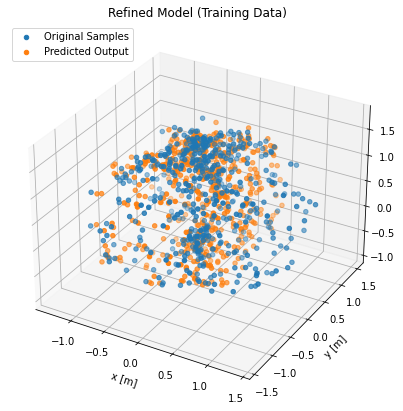

In [60]:
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
 
## training output
ax.scatter3D(y_train[0:500, 0], y_train[0:500, 1], y_train[0:500, 2], 'ro', label='Original Samples')

## predicted output
ax.scatter3D(y_new3_train[0:500, 0], y_new3_train[0:500, 1], y_new3_train[0:500, 2], 'ko', label='Predicted Output')
plt.title('Refined Model (Training Data)')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.legend(loc="upper left")
    
plt.show()

In [75]:
# import pickle 
    
# with open('model_refined/y_new_third_layer.data', 'wb') as filehandle:
#      # store the data as binary data stream
#      pickle.dump(y_new3_train, filehandle)
# with open('model_refined/y_train.data', 'wb') as filehandle:
#       # store the data as binary data stream
#       pickle.dump(y_train, filehandle)
# with open('model_refined/y_predict_train.data', 'wb') as filehandle:
#       # store the data as binary data stream
#       pickle.dump(y_predict_train, filehandle)

In [74]:

y_orig[0,0:3]-y_train[0,0:3]

array([0., 0., 0.])

### Figure Plot

In [76]:
with open('C:/Users/kmajd1/OneDrive - Arizona State University/Summer 2021/NN Repair Project/3-layer NN_Keras/paper_data/forward kinematics/y_predict_train.data', 'rb') as filehandle:
    # read the data as binary data stream
    y_orig = pickle.load(filehandle)

with open('C:/Users/kmajd1/OneDrive - Arizona State University/Summer 2021/NN Repair Project/3-layer NN_Keras/paper_data/forward kinematics/y_new_last_layer.data', 'rb') as filehandle:
    # read the data as binary data stream
    y_4 = pickle.load(filehandle)

with open('C:/Users/kmajd1/OneDrive - Arizona State University/Summer 2021/NN Repair Project/3-layer NN_Keras/paper_data/forward kinematics/y_new_third_layer.data', 'rb') as filehandle:
    # read the data as binary data stream
    y_3 = pickle.load(filehandle)

with open('C:/Users/kmajd1/OneDrive - Arizona State University/Summer 2021/NN Repair Project/3-layer NN_Keras/paper_data/forward kinematics/y_train.data', 'rb') as filehandle:
    # read the data as binary data stream
    y_train = pickle.load(filehandle)

In [121]:
import matplotlib
matplotlib.rcParams['text.usetex'] = True
import matplotlib.pyplot as plt

In [99]:
plt.rcParams['text.usetex'] = True
import matplotlib as mpl
mpl.style.use('default')

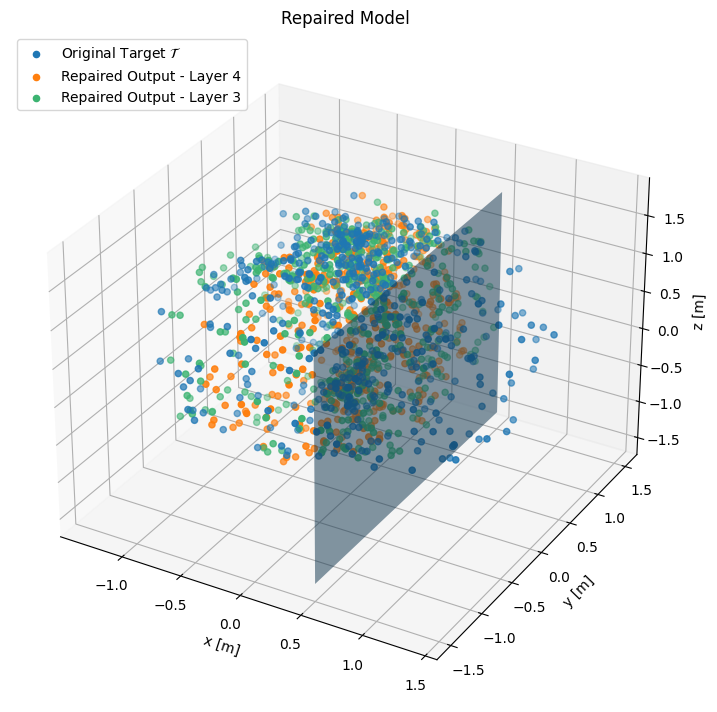

In [122]:
#mpl.style.use('default')
fig=plt.figure(figsize=(10,7))
ax = plt.axes(projection='3d')

## training output
ax.scatter3D(y_train[0:500,0],y_train[0:500,1],y_train[0:500,2],color='tab:blue', label='Original Target $\mathcal{T}$')

## predicted output
ax.scatter3D(y_4[0:500,0],y_4[0:500,1],y_4[0:500,2],color='tab:orange', label='Repaired Output - Layer 4')
ax.scatter3D(y_3[0:500,0],y_3[0:500,1],y_3[0:500,2],color='mediumseagreen', label='Repaired Output - Layer 3')

x = np.array([[0.5, 0.5], [0.5, 0.5]])
y = np.array([[-1.5, 1.5], [-1.5, 1.5]])
z = np.array([[-1.5, -1.5], [1.5, 1.5]])

ax.plot_surface(x, y, z, alpha = 0.5)
ax.set(xlabel='x [m]', ylabel='y [m]', zlabel='z [m]')
#ax.set_facecolor("lavender")
fig.tight_layout()
plt.title('Repaired Model')
#plt.xlabel('x [m]')
#plt.ylabel('y [m]')
plt.legend(loc = 'upper left')
plt.show()


In [87]:
#y_predict_train
#y_train
#y_new_train
#y_new3_train


row,col = y_train.shape

err_orig_in = np.zeros((1,4))
err_orig_out = np.zeros((1,4))
err_4_in = np.zeros((1,4))
err_4_out = np.zeros((1,4))
err_3_in = np.zeros((1,4))
err_3_out = np.zeros((1,4))


n_in = 0
n_out = 0


for i in range(row):
    if y_train[i,0]>0.5:
        err_orig_out = np.linalg.norm(y_orig[i,0:3]-y_train[i,0:3]) + err_orig_out
        err_4_out = np.linalg.norm(y_4[i,0:3]-y_train[i,0:3]) + err_4_out
        err_3_out = np.linalg.norm(y_3[i,0:3]-y_train[i,0:3]) + err_3_out
        n_out += 1
    else:
        err_orig_in = np.linalg.norm(y_orig[i,0:3]-y_train[i,0:3]) + err_orig_in
        err_4_in = np.linalg.norm(y_4[i,0:3]-y_train[i,0:3]) + err_4_in
        err_3_in = np.linalg.norm(y_3[i,0:3]-y_train[i,0:3]) + err_3_in
        n_in += 1
        
err_orig_in = err_orig_in/n_in 
err_4_in = err_4_in/n_in
err_3_in = err_3_in/n_in
err_orig_out = err_orig_out/n_out
err_4_out = err_4_out/n_out
err_3_out = err_3_out/n_out

err_orig_in = (err_orig_in[0,0]+err_orig_in[0,1]+err_orig_in[0,2])/3
err_4_in = (err_4_in[0,0]+err_4_in[0,1]+err_4_in[0,2])/3
err_3_in = (err_3_in[0,0]+err_3_in[0,1]+err_3_in[0,2])/3
err_orig_out = (err_orig_out[0,0]+err_orig_out[0,1]+err_orig_out[0,2])/3
err_4_out = (err_4_out[0,0]+err_4_out[0,1]+err_4_out[0,2])/3
err_3_out = (err_3_out[0,0]+err_3_out[0,1]+err_3_out[0,2])/3

stats_orig = np.array([[err_4_in/err_orig_in, err_3_in/err_orig_in],[err_4_out/err_orig_out, err_3_out/err_orig_out]])
print(stats_orig)

[[2.19988981 2.00832932]
 [6.18079525 5.04492464]]


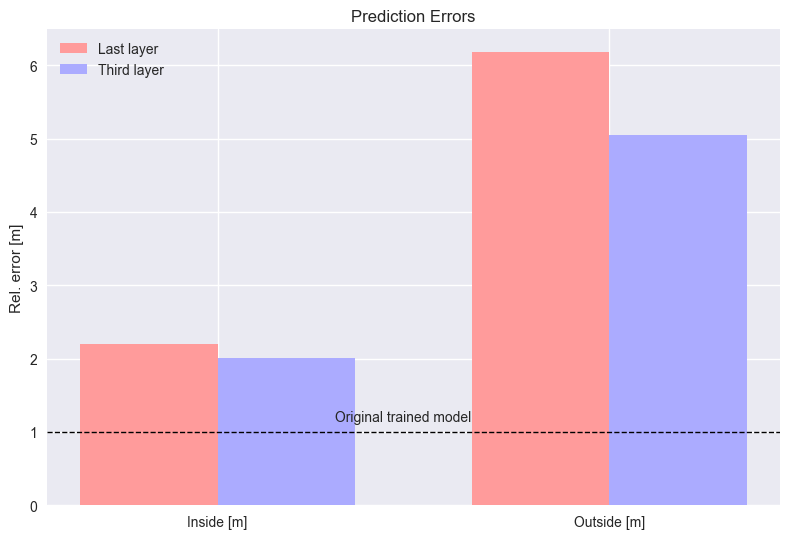

In [123]:
from matplotlib.pyplot import text
mpl.style.use('seaborn')
labels = ['Inside [m]', 'Outside [m]']
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars



fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, stats_orig[0:,0], width, color='#FF9B9B', label='Last layer')
rects2 = ax.bar(x + width/2, stats_orig[0:,1], width, color='#ABABFF', label='Third layer')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Rel. error [m]')
ax.set_title('Prediction Errors')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc="upper left")

plt.axhline(y=1,linewidth=1, color='k',linestyle ="--")
text(0.3, 1.2, "Original trained model", verticalalignment='center')
fig.tight_layout()
plt.show()

## Store Model

In [154]:
model_orig.save('model1\my_model_1')

INFO:tensorflow:Assets written to: model1\my_model_1\assets


In [143]:
import pickle

with open('model1\loss.data', 'wb') as filehandle:
    # store the data as binary data stream
    pickle.dump(his.history['loss'], filehandle)

In [149]:
with open('model1/x_train.data', 'wb') as filehandle:
    # store the data as binary data stream
    pickle.dump(x_train, filehandle)
    
with open('model1/y_train.data', 'wb') as filehandle:
    # store the data as binary data stream
    pickle.dump(y_train, filehandle)
    
with open('model1/x_test.data', 'wb') as filehandle:
    # store the data as binary data stream
    pickle.dump(x_test, filehandle)
    
with open('model1/y_test.data', 'wb') as filehandle:
    # store the data as binary data stream
    pickle.dump(y_test, filehandle)